For this project, my approach is to start by extracting the data from the database, followed by basic data cleaning to ensure quality. Next, I will perform data visualization to gain an initial understanding of the relationship between likes and the other columns. Once this is done, I will implement a traditional model, such as Random Forest Regression, to assess its performance without feature engineering or tuning. If the results are strong, it suggests a high correlation between the default features and like count. However, if the results are not optimal, further fine-tuning will be necessary.

After testing with the traditional model, I will explore a vision-based model like CLIP to evaluate its performance on the data, again starting without tuning before making improvements.

Finally, I will compare the results of both models and conclude which one is better and report the final accuracy of the superior model for this dataset.

# Initial Data Extraction and Analysis

In [214]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [219]:
# Load CSV data
df = pd.read_csv('instagram_data.csv')

df['image_path'] = df['image_path'].str.replace('../Data/insta_data/', 'insta_data/', regex=False)


df = df.dropna(subset=['image_path', 'likes', 'no_of_comments'])

df['datetime'] = pd.to_datetime(df['t'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

### Visualization of the Distribution of Likes

First, I am interested in taking an initial look at the distribution of likes.

/Users/jeffreyju/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


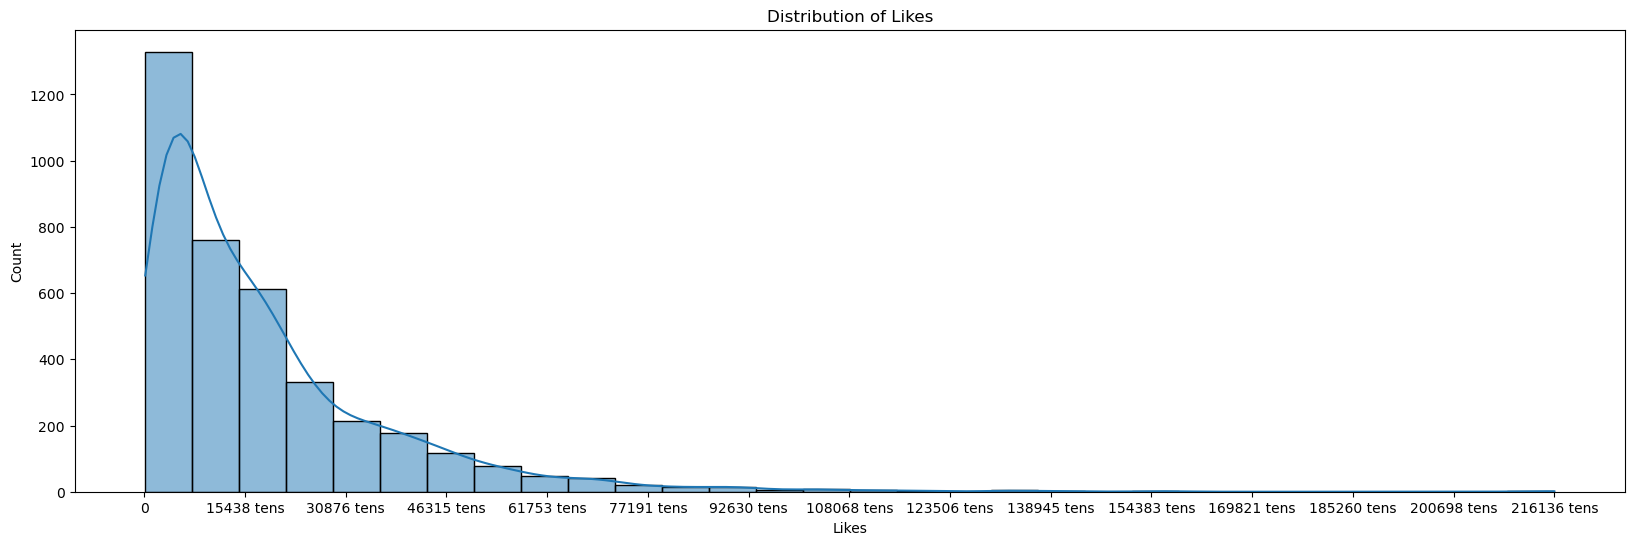

In [220]:
def tens(x, pos):
    if x == 0:
        return '0'
    else:
        return f'{int(x / 10)} tens'

plt.figure(figsize=(20, 6))
sns.histplot(df['likes'], bins=30, kde=True)
plt.title('Distribution of Likes')
plt.xlabel('Likes')

max_likes = df['likes'].max() 
plt.xticks(np.linspace(0, max_likes, 15))  


plt.gca().xaxis.set_major_formatter(FuncFormatter(tens))

plt.show()

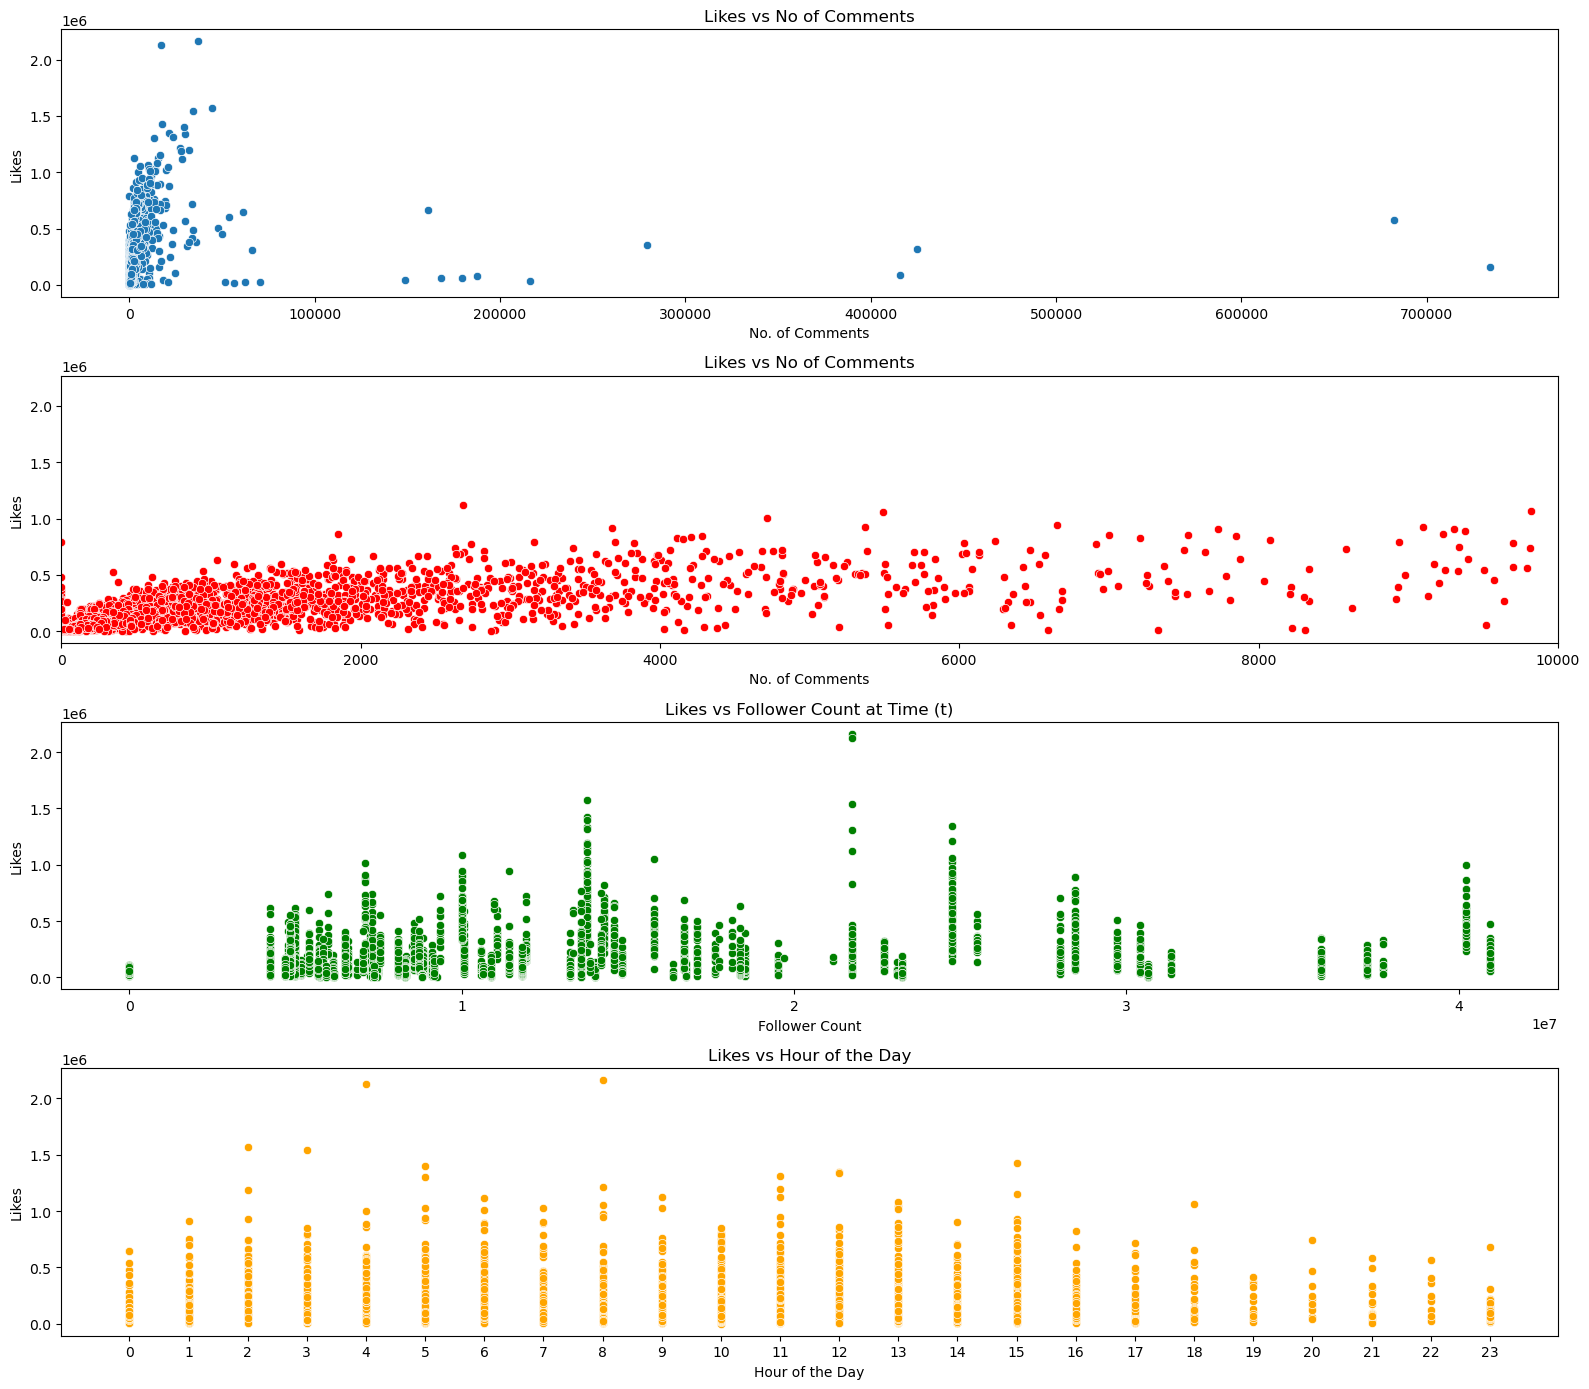

In [229]:
plt.figure(figsize=(16, 14))

# Plot for 'no_of_comments' vs 'likes'
plt.subplot(4, 1, 1)
sns.scatterplot(x=df['no_of_comments'], y=df['likes'])
plt.title('Likes vs No of Comments')
plt.xlabel('No. of Comments')
plt.ylabel('Likes')

# Limiting the x-axis to 10,000 likes
plt.subplot(4, 1, 2)
sns.scatterplot(x=df['no_of_comments'], y=df['likes'], color='red')
plt.title('Likes vs No of Comments')
plt.xlabel('No. of Comments')
plt.ylabel('Likes')
plt.xlim(0, 10000)



# plot for 'follower_count_at_t' vs 'likes'
plt.subplot(4, 1, 3)
sns.scatterplot(x=df['follower_count_at_t'], y=df['likes'], color='green')
plt.title('Likes vs Follower Count at Time (t)')
plt.xlabel('Follower Count')
plt.ylabel('Likes')


# Plot the relationship between likes and hour of day
plt.subplot(4, 1, 4)
sns.scatterplot(x=df['hour'], y=df['likes'], color='orange')
plt.title('Likes vs Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Likes')
plt.xticks(range(0, 24))

plt.tight_layout()

plt.show()


From the graphs, we can see that the none of the 3 initial features shows a strong correlation to number of likes. Intuitively, the number of comments should have a strong correlation to the number of likes. However, the graph shows otherwise as the number of likes stays fairly consistent between the different number of comments.

The Hour of the day graph shows a mostly even distribution with the exception of 19:00 (7PM) showing a lower average like count, which could due to the fact that it is around dinner time. We can also see that 5AM, 11AM, and 3PM shows signs of slightly higher distribution of likes. 

From the Follower Count graph, surprisingly, extremely large accounts (on the right side of the graph) does not outperform the relatively smaller accounts. In fact, accounts with 40 millioin followers shows lower average engagement rate than accounts with 20 million followers.


# Model Implementation

In this step, we will implement two distinct models: a Vision Transformer (CLIP) and a traditional machine learning model (XGBRegressor). We want to explore these two models because we want to study different aspects of the data and gain deeper insights into the factors influencing the number of likes.

First, we will use the CLIP model to examine potential correlations between the images themselves and the number of likes they receive. This will allow us to analyze the visual features within the images and understand whether certain visual elements have a significant impact on engagement. In addition, if the correlation we found is strong, we can determine how many likes a photo will get before it is posted and use this information to help us create better posts.

Next, we will deploy a traditional machine learning model to assess how external factors—such as follower count, comments, and other relevant features—correlate with the number of likes. To enhance the predictive power of the model, we will incorporate feature engineering techniques. This dual-model approach enables us to explore both visual and non-visual factors influencing the target variable.

Lastly, we will combine the features used for a traditional model with features extracted from the images and examine the combined results.

By combining insights from both models, we aim to achieve a comprehensive understanding of what drives user engagement and identify the strongest predictors for likes.

In [207]:
import os
import numpy as np
import pandas as pd
import torch
import clip
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, mean_absolute_error,
    mean_squared_error, r2_score
)
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm  
from sklearn.decomposition import PCA


In [230]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

First, we will create a function that creates extra features based on the default ones we were given. These extra features can aid in boosting the predictive power of the model.

In [231]:
def engineer_features(df):
    df['datetime'] = pd.to_datetime(df['t'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    


    df['engagement_rate'] = df['likes'] / df['follower_count_at_t'] * 100
    


    df['log_likes'] = np.log1p(df['likes'])
    df['log_follower_count'] = np.log1p(df['follower_count_at_t'])
    

    df['follower_comment_interaction'] = df['follower_count_at_t'] * df['no_of_comments']
    
    df['follower_count_bin'] = pd.qcut(
        df['follower_count_at_t'],
        q=5,
        labels=[1, 2, 3, 4, 5],
        duplicates='drop' 
    )

    df = df.sort_values(['follower_count_at_t', 't'])
    df['rolling_avg_likes'] = df.groupby('follower_count_at_t')['likes'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )
    
    df['avg_likes_per_account'] = df.groupby('follower_count_at_t')['likes'].transform('mean')
    df['relative_popularity'] = df['likes'] / df['avg_likes_per_account']

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    

    df['follower_count_bin'] = df['follower_count_bin'].fillna(1)
    df['follower_count_bin'] = df['follower_count_bin'].astype(int)
    
    df.fillna(0, inplace=True)
    
    return df


# Apply feature engineering
df = engineer_features(df)


In [232]:
features = [
    'no_of_comments', 'follower_count_at_t', 'hour', 'day_of_week', 'month', 
    'is_weekend', 'engagement_rate', 'log_follower_count', 
    'follower_comment_interaction', 'follower_count_bin', 
    'rolling_avg_likes', 'relative_popularity'
]

X_structured = df[features].reset_index(drop=True)

X_structured['follower_count_bin'] = X_structured['follower_count_bin'].astype(int)

y_regression = df['log_likes']


Next, we use the CLIP model to study the photo dataset we are given and extract features from each photo

In [233]:
image_features = []
print("Extracting image features using CLIP...")
for idx, image_path in enumerate(tqdm(df['image_path'], desc='Processing images')):
    try:
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_feature = model.encode_image(image)
        image_features.append(image_feature.cpu().numpy()[0])
    except Exception as e:
        print(f"Error processing image at index {idx}: {e}")
        image_features.append(np.zeros(model.visual.output_dim))

image_features_df = pd.DataFrame(image_features)
image_features_df.columns = [
    f'feature_{i}' for i in range(image_features_df.shape[1])]

Extracting image features using CLIP...


Processing images: 100%|██████████| 3785/3785 [4:26:41<00:00,  4.23s/it]     


After extracting the image features with CLIP, the data can be very high-dimensioned and can potentially have thousands of features, hence we will want to apply PCA to reduce the dimension of the data. This also prevents the risk of overfitting and increases computational efficiency. 

In [234]:
scaler = StandardScaler()
image_features_std = scaler.fit_transform(image_features_df)


pca = PCA(n_components=0.95, random_state=42)
image_features_pca = pca.fit_transform(image_features_std)
n_components = image_features_pca.shape[1]
print(f'Number of components to retain 95% variance: {n_components}')



image_features_pca_df = pd.DataFrame(
    image_features_pca,
    columns=[f'pca_feature_{i}' for i in range(n_components)]
)

X_clip = image_features_pca_df.reset_index(drop=True)

Number of components to retain 95% variance: 352


In order to classify the likes into 3 categories, we will use quantiles 0%-33%, 33%-66%, and 66%-100%

In [259]:
thresholds = df['likes'].quantile([0.33, 0.66]).values

def categorize_likes(likes):
    if likes <= thresholds[0]:
        return 'Low'
    elif likes <= thresholds[1]:
        return 'Medium'
    else:
        return 'High'

df['likes_category'] = df['likes'].apply(categorize_likes)
y_classification = df['likes_category']


# Encode classification labels
le = LabelEncoder()
y_classification_encoded = le.fit_transform(y_classification)

Now we have defined our features for both the clip model and the traditional model and have defined the categories that we will split the likes into, we will define how we will be implementing the models.

We will train and evaluate both regression and classification models using the XGBoost algorithm on the given dataset and features. The function begins by splitting the data into training and test sets for both regression and classification tasks using an 80-20 split. It then standardizes the features with StandardScaler to ensure that all features contribute equally to the model training. For regression, it performs hyperparameter tuning using GridSearchCV on an XGBRegressor, optimizing parameters like the number of estimators, maximum depth, and learning rate. After training the best model, it predicts on the test set, transforms the predictions back from the logarithmic scale, and calculates performance metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared. For classification, the function similarly tunes an XGBClassifier and evaluates its performance by calculating the accuracy and generating a classification report that includes precision, recall, and F1-score for each class.

In [236]:
def train_evaluate_model(X, y_reg, y_clf_enc, dataset_name):
    print(f"\n Training and Evaluating Models using {dataset_name}")
    
    # Split data for regression
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X, y_reg, test_size=0.2, random_state=42)
    
    # Split data for classification
    X_train_clf, X_test_clf, y_train_clf_enc, y_test_clf_enc = train_test_split(
        X, y_clf_enc, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_reg = scaler.fit_transform(X_train_reg)
    X_test_reg = scaler.transform(X_test_reg)
    X_train_clf = scaler.fit_transform(X_train_clf)
    X_test_clf = scaler.transform(X_test_clf)
    
    print("\nStarting regression model training with XGBoost...")
    
    param_grid_reg = {
        'n_estimators': [100],
        'max_depth': [5],
        'learning_rate': [0.1],
    }
    
    grid_search_reg = GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=42, verbosity=0),
        param_grid=param_grid_reg,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search_reg.fit(X_train_reg, y_train_reg)
    
    best_regressor = grid_search_reg.best_estimator_
    
    y_pred_reg_log = best_regressor.predict(X_test_reg)
    
    y_pred_reg = np.expm1(y_pred_reg_log)
    y_test_reg_exp = np.expm1(y_test_reg)
    
    mae_reg = mean_absolute_error(y_test_reg_exp, y_pred_reg)
    rmse_reg = mean_squared_error(y_test_reg_exp, y_pred_reg, squared=False)
    r2_reg = r2_score(y_test_reg_exp, y_pred_reg)
    
    print(f"Regression MAE: {mae_reg:.2f}")
    print(f"Regression RMSE: {rmse_reg:.2f}")
    print(f"Regression R-squared: {r2_reg:.4f}")

    
    print("\nStarting classification model training with XGBoost...")
    
    param_grid_clf = {
        'n_estimators': [100],
        'max_depth': [5],
        'learning_rate': [0.1],
    }
    

    grid_search_clf = GridSearchCV(
        estimator=xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
        param_grid=param_grid_clf,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    

    grid_search_clf.fit(X_train_clf, y_train_clf_enc)


    best_classifier = grid_search_clf.best_estimator_
    

    y_pred_clf_enc = best_classifier.predict(X_test_clf)
    y_pred_clf = le.inverse_transform(y_pred_clf_enc)
    y_test_clf = le.inverse_transform(y_test_clf_enc)
    

    accuracy = accuracy_score(y_test_clf, y_pred_clf)
    print(f"Classification Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_clf, y_pred_clf))


We will first evaluate the accuracy of the prediction when we only use features extracted by the CLIP model. 

In [237]:
train_evaluate_model(X_clip, y_regression, y_classification_encoded, dataset_name='CLIP')


 Training and Evaluating Models using CLIP

Starting regression model training with XGBoost...
Regression MAE: 105281.46
Regression RMSE: 173145.53
Regression R-squared: 0.1284

Starting classification model training with XGBoost...
Classification Accuracy: 0.5271
Classification Report:
              precision    recall  f1-score   support

        High       0.57      0.62      0.60       250
         Low       0.57      0.57      0.57       248
      Medium       0.43      0.39      0.41       259

    accuracy                           0.53       757
   macro avg       0.52      0.53      0.53       757
weighted avg       0.52      0.53      0.52       757



As we can see, the predictive power using only CLIP image features is not ideal as the accuracy hovers only a little above 50%. Next, we will try again using structured features and compare the results. 

In [238]:
train_evaluate_model(X_structured, y_regression, y_classification_encoded, dataset_name='Structured Features')


 Training and Evaluating Models using Structured Features

Starting regression model training with XGBoost...
Regression MAE: 14873.75
Regression RMSE: 27550.33
Regression R-squared: 0.9779

Starting classification model training with XGBoost...
Classification Accuracy: 0.9683
Classification Report:
              precision    recall  f1-score   support

        High       0.97      0.96      0.97       250
         Low       0.99      0.98      0.99       248
      Medium       0.95      0.96      0.95       259

    accuracy                           0.97       757
   macro avg       0.97      0.97      0.97       757
weighted avg       0.97      0.97      0.97       757



In comparison, the predictive power of the model using structured features is drastically better than using CLIP image features as the accuracy in categorizing is 97% on average. This shows that the photos themselves plays a significantly smaller role in social media engagement than other aspects of the account.

### Removing Number of Comments

When we initially engineered the structured features, we included the number of comments as an important factor. However, if our goal is to predict the number of likes a photo might receive before it is posted, the number of comments—along with any features related to post-engagement—must be excluded from the model.

By removing these features, we ensure that the model relies solely on information available before the photo is shared, such as visual content, follower count, and other relevant pre-posting metrics. This will improve the model’s robustness and make its predictions more realistic and applicable in real-world scenarios.

In [272]:
df['log_likes'] = np.log1p(df['likes'])

def engineer_features(df):
    df['datetime'] = pd.to_datetime(df['t'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    

    df['log_follower_count'] = np.log1p(df['follower_count_at_t'])
    

    df['follower_count_bin'] = pd.qcut(
        df['follower_count_at_t'],
        q=5,
        labels=[1, 2, 3, 4, 5],
        duplicates='drop'
    )
    df['follower_count_bin'] = df['follower_count_bin'].fillna(1).astype(int)
    

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    

    df.fillna(0, inplace=True)
    
    return df


df = engineer_features(df)


In [274]:
features = [
    'follower_count_at_t', 'hour', 'day_of_week', 'month', 
    'is_weekend', 'log_follower_count', 'follower_count_bin'
]



X_structured = df[features].reset_index(drop=True)


X_structured['follower_count_bin'] = X_structured['follower_count_bin'].astype(int)


y_regression = df['log_likes']


In [266]:
train_evaluate_model(X_structured, y_regression, y_classification_encoded, dataset_name='Structured Features (Without Post-Engagement Features)')


 Training and Evaluating Models using Structured Features (Without Post-Engagement Features)

Starting regression model training with XGBoost...
Regression MAE: 77150.01
Regression RMSE: 135857.65
Regression R-squared: 0.4577

Starting classification model training with XGBoost...
Classification Accuracy: 0.6618
Classification Report:
              precision    recall  f1-score   support

        High       0.80      0.65      0.72       268
         Low       0.72      0.74      0.73       255
      Medium       0.50      0.59      0.54       234

    accuracy                           0.66       757
   macro avg       0.67      0.66      0.66       757
weighted avg       0.68      0.66      0.67       757



The result shows us that the number of comments that a post gets is an important metric in predicting the number of likes that a photo might get. By removing it as a metric, the accuracy of the model dropped from 97% to 68%. This is a more accurate representation of the predictive power of the model.

### Combining Traditional Features and Image Features

Lastly, we have to test the predictive power of the model based on the combined features from CLIP features and structure features. By combining the features, the performance of the model might see an increase due to the combined features, it might also see a decrease if the CLIP image features creates more noise than contribute to the predictions.

In [242]:
X_combined = pd.concat([X_structured, X_clip], axis=1)

train_evaluate_model(X_combined, y_regression, y_classification_encoded, dataset_name='Combined Structured and CLIP Features')


 Training and Evaluating Models using Combined Structured and CLIP Features

Starting regression model training with XGBoost...
Regression MAE: 90846.70
Regression RMSE: 150366.64
Regression R-squared: 0.3427

Starting classification model training with XGBoost...
Classification Accuracy: 0.6024
Classification Report:
              precision    recall  f1-score   support

        High       0.66      0.68      0.67       250
         Low       0.63      0.65      0.64       248
      Medium       0.51      0.47      0.49       259

    accuracy                           0.60       757
   macro avg       0.60      0.60      0.60       757
weighted avg       0.60      0.60      0.60       757



The results indicate that combining structured features with CLIP image features did not enhance the predictive performance of the models in this case. The structured features alone seem to capture more relevant information for predicting the number of likes and classifying posts into 'Low', 'Medium', or 'High' categories. This means that the image themselves does not contribute much to how many likes a photo might get, structured features plays a much more important role. 

# Conclusion

In this last section, we will plot the combination of followers and time of day to find out how to maximize the like count we can get on a post

In [270]:
df.head()

,likes,no_of_comments,t,follower_count_at_t,image_path,datetime,hour,day_of_week,month,is_weekend,log_follower_count,follower_count_bin,likes_category,log_likes
0,154552,0,1594174009,40934474,insta_data/0.jpg,2020-07-08 02:06:49,2,2,7,0,17.527483,5,Medium,11.948292
1,97386,0,1593571666,40934474,insta_data/2.jpg,2020-07-01 02:47:46,2,2,7,0,17.527483,5,Medium,11.486448
2,145632,0,1593136341,40934474,insta_data/4.jpg,2020-06-26 01:52:21,1,4,6,0,17.527483,5,Medium,11.888845
3,76461,0,1592981047,40934474,insta_data/6.jpg,2020-06-24 06:44:07,6,2,6,0,17.527483,5,Medium,11.244549
4,174620,0,1592703461,40934474,insta_data/8.jpg,2020-06-21 01:37:41,1,6,6,1,17.527483,5,Medium,12.070373



Top 10 time periods and follower counts resulting in high like percentage:
likes_category           High_percentage  total
hour follower_count_bin                        
20   3                        100.000000      1
22   5                        100.000000      2
     4                        100.000000      4
21   5                        100.000000      2
18   5                        100.000000      5
19   5                        100.000000      2
18   3                         71.428571      7
17   3                         70.000000     10
15   3                         62.337662    154
20   5                         60.000000      5

Top 10 time periods and follower counts resulting in low like percentage:
likes_category           Low_percentage  total
hour follower_count_bin                       
22   3                       100.000000      2
18   1                       100.000000      2
20   1                       100.000000      1
22   1                       100.00000

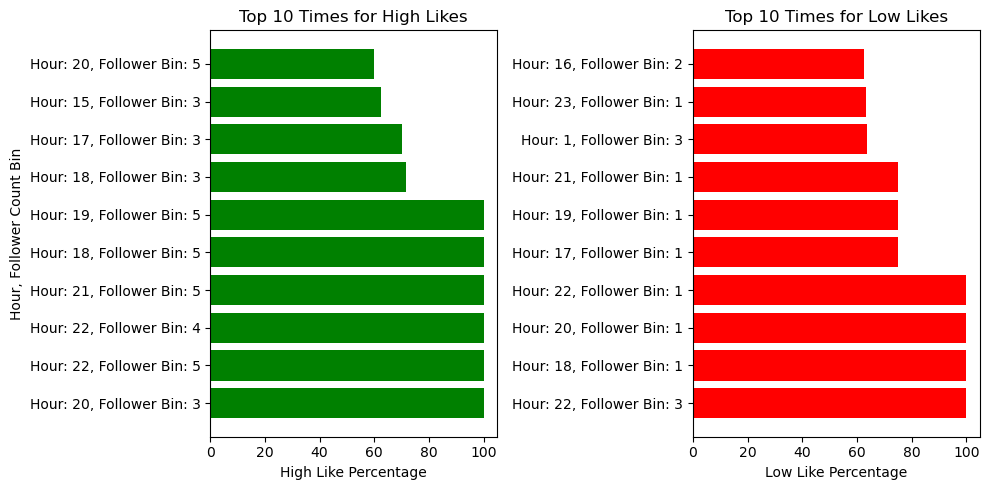

In [276]:
def analyze_likes_by_time_and_followers(df):
    analysis_df = df.groupby(['hour', 'follower_count_bin', 'likes_category']).size().unstack(fill_value=0)

    analysis_df['total'] = analysis_df.sum(axis=1)
    

    if 'High' in analysis_df:
        analysis_df['High_percentage'] = (analysis_df['High'] / analysis_df['total']) * 100
    else:
        analysis_df['High_percentage'] = 0

    if 'Low' in analysis_df:
        analysis_df['Low_percentage'] = (analysis_df['Low'] / analysis_df['total']) * 100
    else:
        analysis_df['Low_percentage'] = 0
    


    high_like_times = analysis_df.sort_values('High_percentage', ascending=False).head(10)
    low_like_times = analysis_df.sort_values('Low_percentage', ascending=False).head(10)
    
    print("\nTop 10 time periods and follower counts resulting in high like percentage:")
    print(high_like_times[['High_percentage', 'total']])
    
    print("\nTop 10 time periods and follower counts resulting in low like percentage:")
    print(low_like_times[['Low_percentage', 'total']])
    
    return high_like_times, low_like_times

def plot_like_analysis(high_like_times, low_like_times):
    high_like_times.index = high_like_times.index.map(lambda x: f'Hour: {x[0]}, Follower Bin: {x[1]}')
    low_like_times.index = low_like_times.index.map(lambda x: f'Hour: {x[0]}, Follower Bin: {x[1]}')
    
    plt.figure(figsize=(10, 5))
    

    plt.subplot(1, 2, 1)
    plt.barh(high_like_times.index, high_like_times['High_percentage'], color='green')
    plt.title('Top 10 Times for High Likes')
    plt.xlabel('High Like Percentage')
    plt.ylabel('Hour, Follower Count Bin')
    
    plt.subplot(1, 2, 2)
    plt.barh(low_like_times.index, low_like_times['Low_percentage'], color='red')
    plt.title('Top 10 Times for Low Likes')
    plt.xlabel('Low Like Percentage')
    
    plt.tight_layout()
    plt.show()


high_like_times, low_like_times = analyze_likes_by_time_and_followers(df)


plot_like_analysis(high_like_times, low_like_times)

In [279]:
bin_edges = pd.qcut(df['follower_count_at_t'], q=5, duplicates='drop').unique()


for i, bin_range in enumerate(bin_edges):
    print(f"Bin {i+1} range: {bin_range}")


bin_counts = df['follower_count_bin'].value_counts().sort_index()

print("\nNumber of posts in each bin:")
print(bin_counts)


Bin 1 range: (21737604.0, 40934474.0]
Bin 2 range: (13602143.0, 21737604.0]
Bin 3 range: (8838196.0, 13602143.0]
Bin 4 range: (6496178.0, 8838196.0]
Bin 5 range: (186.999, 6496178.0]

Number of posts in each bin:
follower_count_bin
1    810
2    728
3    736
4    796
5    715
Name: count, dtype: int64


In this study, we explored the effectiveness of different feature sets for predicting social media post engagement, specifically the number of likes a post might receive before it's published. Models trained solely on CLIP-extracted image features demonstrated poor performance, with low R-squared values (~0.13) and classification accuracies around 53%, indicating that image content alone is insufficient for accurate predictions. When using structured features that included post-engagement data (like the number of comments), the models achieved exceptionally high performance (R-squared ~0.98, classification accuracy ~97%), but this likely resulted from data leakage since such features wouldn't be available prior to posting. Models utilizing structured features without post-engagement data showed moderate predictive power (R-squared ~0.52, classification accuracy ~67%), suggesting that time-based features and follower counts contribute meaningfully to engagement predictions. Combining structured features with CLIP image features did not enhance model performance and, in fact, led to decreased accuracy and R-squared values. Therefore, the study concludes that structured pre-posting features are more effective than image features for predicting post engagement, and caution must be taken to avoid data leakage by excluding post-engagement metrics from predictive models.

In the end, we concluded that posts coming from accounts with followers ranging from around 186 to 8,838,196 and posted from 6PM to 10PM has the highest likelihood of having high like counts. On the other hand, posts coming from accounts with followers ranging from 13,602,143 to 40,934,474 posted around 6PM to 10PM have the highest probability of having low like counts. It is also important to note that the accuracy of the model is only around 68%, so we have to take these results with a grain of salt. 